## тестирование стратегии на промежутке дней (год)

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from dotenv import load_dotenv
from datetime import datetime

load_dotenv()

TOKEN = os.getenv("INVEST_TOKEN")

TICKER = 'RNFT'
FIGI = 'BBG00F9XX7H4'

In [82]:
from trader_bot import ScalpingBot
from historical_data import HistoricalDataHandler

from test_env.client_test_env import ClientTestEnvHelper
from test_env.logger_test_env import LoggerTestEnvHelper
from test_env.time_test_env import TimeTestEnvHelper
from test_env.accounting_test_env import AccountingTestEnvHelper

def test_algorythm(
        last_test_date = '2024-03-15',
        test_days_num = 251,
        profit_steps=5, 
        candles_count=4, 
        sleep_trading=5 * 60, 
        sleep_no_trade=300, 
        no_operation_timeout_seconds=300,
        ):
    time_helper = TimeTestEnvHelper()
    
    logger_helper = LoggerTestEnvHelper(time_helper, do_printing=False)
    
    client_helper = ClientTestEnvHelper(TICKER, logger_helper, time_helper)
    client_helper.set_ticker_params(1, 0.1, FIGI, 'RUR')
    
    accounting_helper = AccountingTestEnvHelper(client_helper)
    
    data_handler = HistoricalDataHandler(TOKEN, FIGI, TICKER)
    
    days_list = data_handler.get_days_list(last_test_date, test_days_num)
    
    # создаем бота с настройками
    bot = ScalpingBot(
        TOKEN, 
        TICKER,
    
        profit_steps=profit_steps,
        candles_count=candles_count,
        
        sleep_trading=sleep_trading,
        sleep_no_trade=sleep_no_trade,
        no_operation_timeout_seconds=no_operation_timeout_seconds,
    
        time_helper=time_helper,
        logger_helper=logger_helper,
        client_helper=client_helper,
        accounting_helper=accounting_helper,
    )
    
    balance = 0
    success_days = 0
    balance_change_list = []
    operations_cnt = 0
    operations_not_closed_cnt = 0
    operations_cnt_list = []
    
    # закручиваем цикл по датам
    for test_date in days_list:
    
        # прогоняем по дню (-3 часа для компенсации часового сдвига)
        date_from = datetime.strptime(test_date + ' 07:30', "%Y-%m-%d %H:%M")   # 10:30
        date_to   = datetime.strptime( test_date + ' 15:30', "%Y-%m-%d %H:%M")  # 18:30
        
        # задаем параметры дня
        time_helper.set_current_time(date_from)
        bot.reset_last_operation_time()
        client_helper.set_candles_list(data_handler.get_candles(test_date))
        
        accounting_helper.reset()
    
        # Использование итератора для вывода каждой пары час-минута
        for dt in data_handler.get_hour_minute_pairs(date_from, date_to):
            # задаем время
            time_helper.set_time(dt)
            
            candle = client_helper.get_candle(dt)
            if candle is None:
                logger_helper.error(f"No candle for {dt}")        
                continue
            
            # задаем текущее значение свечи
            client_helper.set_current_candle(candle)
            
            # анализируем заявки - успешные помечаем
            if bot.buy_order:
                buy_price = client_helper.quotation_to_float(bot.buy_order.initial_order_price)
                low_buy_price = client_helper.quotation_to_float(candle.low)
                if buy_price >= low_buy_price:
                    client_helper.buy_order_executed = True
                    client_helper.buy_order_executed_on_border = buy_price == low_buy_price
        
            if bot.sell_order:
                sell_price = client_helper.quotation_to_float(bot.sell_order.initial_order_price)
                high_sell_price = client_helper.quotation_to_float(candle.high)
                if sell_price <= high_sell_price:
                    client_helper.sell_order_executed = True
                    client_helper.sell_order_executed_on_border = sell_price == high_sell_price
        
            # если пора просыпаться
            if time_helper.is_time_to_awake():
                # print(dt.strftime("%H:%M"))
                # запускаем итерацию торгового алгоритма
                bot.run_iteration()
        
        bot.stop()
        
        operations = len(accounting_helper.deals)
        operations_cnt += operations
        operations_cnt_list.append(operations)
        if client_helper.sell_order_executed % 2 == 1:
            operations_not_closed_cnt += 1
        
        balance_change = round(accounting_helper.sum, 2)
        balance = round(balance + balance_change, 2)
        
        if balance_change > 0:
            success_days += 1
            
        balance_change_list.append(balance_change)
                
    return {
        'balance': balance,
        'days': test_days_num,
        'balance_change_avg': round(sum(balance_change_list) / test_days_num, 2),
        'success_days': success_days,
        'success_p': round(success_days / test_days_num, 2),
        'profit_steps': profit_steps,
        'candles_count': candles_count,
        'sleep_trading': sleep_trading,
        'operations_cnt': operations_cnt,
        'operations_avg': round(sum(operations_cnt_list) / test_days_num, 2),
        'op_not_closed': operations_not_closed_cnt,
        'op_not_closed_avg': round(operations_not_closed_cnt / test_days_num, 2),
    }
        

# print(test_algorythm(
#     last_test_date = '2024-03-15',
#     test_days_num = 5, # 251,
# 
#     profit_steps=5, 
#     candles_count=4, 
# 
#     sleep_trading=5 * 60, 
#     sleep_no_trade=300, 
#     no_operation_timeout_seconds=300,
# ))

results = []

# for profit_steps in [2]:
#     for candles_count in [2]:
#         for sleep_trading in [1*60]:
#             for no_operation_timeout_seconds in [1*60]:
for profit_steps in [5, 6, 7]:
    for candles_count in [3, 4, 5]:
        for sleep_trading in [5*60, 7*60, 10*60]:
            res = test_algorythm(
                last_test_date = '2024-03-15',
                test_days_num = 30, # 251,
            
                profit_steps=profit_steps, 
                candles_count=candles_count, 
            
                sleep_trading=sleep_trading, 
                sleep_no_trade=300, 
                no_operation_timeout_seconds=300,
            )
            print('.', end='')
            results.append(res)
            
sorted_results = sorted(results, key=lambda x: x['balance'], reverse=True)

print()
for item in sorted_results:
    print(item)


...........................
{'balance': 8.3, 'days': 30, 'balance_change_avg': 0.28, 'success_days': 10, 'success_p': 0.33, 'profit_steps': 7, 'candles_count': 5, 'sleep_trading': 420, 'operations_cnt': 62, 'operations_avg': 2.07, 'op_not_closed': 8, 'op_not_closed_avg': 0.27}
{'balance': 6.2, 'days': 30, 'balance_change_avg': 0.21, 'success_days': 5, 'success_p': 0.17, 'profit_steps': 7, 'candles_count': 3, 'sleep_trading': 300, 'operations_cnt': 36, 'operations_avg': 1.2, 'op_not_closed': 6, 'op_not_closed_avg': 0.2}
{'balance': 5.5, 'days': 30, 'balance_change_avg': 0.18, 'success_days': 4, 'success_p': 0.13, 'profit_steps': 7, 'candles_count': 3, 'sleep_trading': 600, 'operations_cnt': 24, 'operations_avg': 0.8, 'op_not_closed': 4, 'op_not_closed_avg': 0.13}
{'balance': 4.1, 'days': 30, 'balance_change_avg': 0.14, 'success_days': 7, 'success_p': 0.23, 'profit_steps': 7, 'candles_count': 3, 'sleep_trading': 420, 'operations_cnt': 76, 'operations_avg': 2.53, 'op_not_closed': 9, 'op_n

In [83]:
sorted_results_archive = sorted_results

sorted_results_archive

[{'balance': 8.3,
  'days': 30,
  'balance_change_avg': 0.28,
  'success_days': 10,
  'success_p': 0.33,
  'profit_steps': 7,
  'candles_count': 5,
  'sleep_trading': 420,
  'operations_cnt': 62,
  'operations_avg': 2.07,
  'op_not_closed': 8,
  'op_not_closed_avg': 0.27},
 {'balance': 6.2,
  'days': 30,
  'balance_change_avg': 0.21,
  'success_days': 5,
  'success_p': 0.17,
  'profit_steps': 7,
  'candles_count': 3,
  'sleep_trading': 300,
  'operations_cnt': 36,
  'operations_avg': 1.2,
  'op_not_closed': 6,
  'op_not_closed_avg': 0.2},
 {'balance': 5.5,
  'days': 30,
  'balance_change_avg': 0.18,
  'success_days': 4,
  'success_p': 0.13,
  'profit_steps': 7,
  'candles_count': 3,
  'sleep_trading': 600,
  'operations_cnt': 24,
  'operations_avg': 0.8,
  'op_not_closed': 4,
  'op_not_closed_avg': 0.13},
 {'balance': 4.1,
  'days': 30,
  'balance_change_avg': 0.14,
  'success_days': 7,
  'success_p': 0.23,
  'profit_steps': 7,
  'candles_count': 3,
  'sleep_trading': 420,
  'operation

                     balance  days  balance_change_avg  success_days  \
balance             1.000000   NaN            0.999915 -2.482241e-01   
days                     NaN   NaN                 NaN           NaN   
balance_change_avg  0.999915   NaN            1.000000 -2.486057e-01   
success_days       -0.248224   NaN           -0.248606  1.000000e+00   
success_p          -0.241848   NaN           -0.242294  9.995998e-01   
profit_steps        0.540816   NaN            0.544526 -5.200483e-01   
candles_count      -0.077613   NaN           -0.076729  1.229239e-16   
sleep_trading       0.244645   NaN            0.244239 -4.155145e-01   
operations_cnt     -0.608605   NaN           -0.609707  8.102226e-01   
operations_avg     -0.608401   NaN           -0.609507  8.104062e-01   
op_not_closed      -0.564936   NaN           -0.566141  7.782444e-01   
op_not_closed_avg  -0.565537   NaN           -0.566736  7.817148e-01   

                    success_p  profit_steps  candles_count  sle

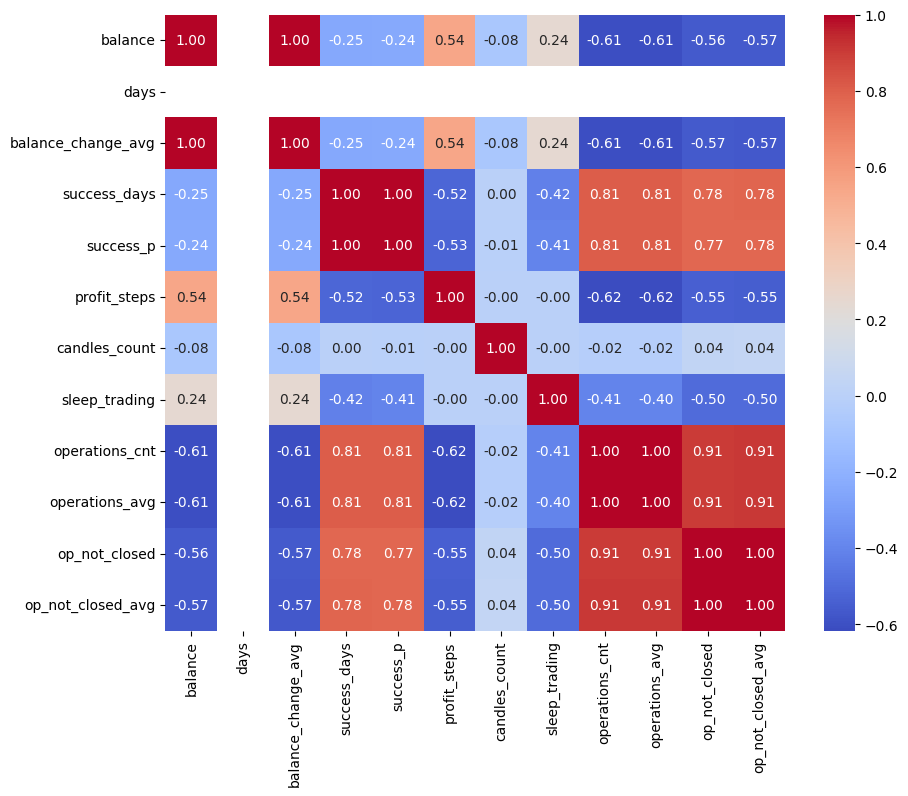

In [85]:
import pandas as pd

# Предположим, что data - это ваш список объектов
data = sorted_results

# Преобразование списка словарей в DataFrame
df = pd.DataFrame(data)

# Вычисление таблицы корреляции
correlation_matrix = df.corr()

# Вывод таблицы корреляции
print(correlation_matrix)

# Для более наглядного отображения можно использовать seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()